In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
import serial
from matplotlib import cm
import subprocess


11146
8000


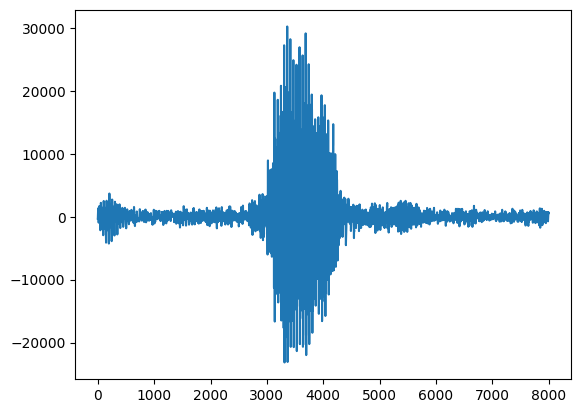

In [2]:
# Dataset path and view possible targets
# filename  = '../data_speech_commands_v0.02/four/0a2b400e_nohash_0.wav'  #Four
# filename  = '../data_speech_commands_v0.02/right/0a2b400e_nohash_3.wav' #Right
# filename  = '../data_speech_commands_v0.02/stop/0a196374_nohash_0.wav'  #Stop
filename  = '../my_eight.wav'  #Eight

signal, fs = librosa.load(filename, sr=8000)
signal=signal*(2**15)
print(len(signal))
signal = signal[0:8000]
print(len(signal))
function=signal.astype(np.int16)
np.savetxt('time_series_1s.dat', function, fmt='%d', delimiter='\n')


plt.plot(signal)

In [4]:
subprocess.run("cd ../ ; pio run -t upload", shell=True)

ser = serial.Serial()
ser.baudrate = 115200
ser.port = '/dev/cu.usbserial-565C0062681'
ser.open()

for i in range(20):            # 256 = 16*16
    b = ser.readline()          # read a byte string
    str_rn = b.decode()
    str_input = str_rn.rstrip()
    print(f"{i}  : {str_input}")
    if str_input == "Setup done":
        break

ser.close()

Processing featheresp32 (platform: espressif32; board: featheresp32; framework: arduino)
--------------------------------------------------------------------------------
Verbose mode can be enabled via `-v, --verbose` option
CONFIGURATION: https://docs.platformio.org/page/boards/espressif32/featheresp32.html
PLATFORM: Espressif 32 (6.3.1) > Adafruit ESP32 Feather
HARDWARE: ESP32 240MHz, 320KB RAM, 4MB Flash
DEBUG: Current (cmsis-dap) External (cmsis-dap, esp-bridge, esp-prog, iot-bus-jtag, jlink, minimodule, olimex-arm-usb-ocd, olimex-arm-usb-ocd-h, olimex-arm-usb-tiny-h, olimex-jtag-tiny, tumpa)
PACKAGES: 
 - framework-arduinoespressif32 @ 3.20009.0 (2.0.9) 
 - tool-esptoolpy @ 1.40501.0 (4.5.1) 
 - tool-mkfatfs @ 2.0.1 
 - tool-mklittlefs @ 1.203.210628 (2.3) 
 - tool-mkspiffs @ 2.230.0 (2.30) 
 - toolchain-xtensa-esp32 @ 8.4.0+2021r2-patch5
LDF: Library Dependency Finder -> https://bit.ly/configure-pio-ldf
LDF Modes: Finder ~ chain, Compatibility ~ soft
Found 35 compatible libraries

In [5]:
# Send Signal from Python & Return MFCC from ESP32
a= function
a= a.astype(np.int16)
# a= a.astype(np.int32)


ser = serial.Serial()
ser.baudrate = 115200
ser.port = '/dev/cu.usbserial-565C0062681'
ser.open()

for i in range(len(a)):
    values = str(a[i])
    send=bytearray(values, encoding='utf8')
    jumpline=bytearray('\n', encoding='utf8')
    ser.write(send)
    ser.write(jumpline)
    # print(f"send   [{i}]  : {send}")
    
data = []                       # empty list to store the data
for i in range(256):            # 256 = 16*16
    b = ser.readline()          # read a byte string
    str_rn = b.decode()
    str_input = str_rn.rstrip()
    data.append(str_input)
    print(f"{i}  : {str_input}")
    
    
mfcc=np.array(data)
# mfcc=mfcc.astype(np.int16)
mfcc=mfcc.astype(np.float16)

    


ser.close()
print(len(mfcc))

KeyboardInterrupt: 

In [6]:
# Plotting MFCC from ESP32 serial data
%matplotlib inline


plt.figure(figsize=(6,6))
plt.plot(mfcc,'r')
plt.show()

mfcc_from_time_series = mfcc.reshape(16,16)
# print(mfcc_from_time_series.shape)

plt.figure(figsize=(6,6))
fig, ax = plt.subplots(figsize=(6,6))
mfcc_from_time_series= np.swapaxes(mfcc_from_time_series, 0 ,1)
cax = ax.imshow(mfcc_from_time_series, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()


NameError: name 'mfcc' is not defined

<Figure size 600x600 with 0 Axes>

In [9]:
# Run MFCC on computer
# Change -DFFTXXXX to the desired FFT size
subprocess.run('g++ -Dcomputer compute_mfcc.cpp -o compute_mfcc' , shell=True)  
subprocess.run(["./compute_mfcc"], shell=True)

CompletedProcess(args=['./compute_mfcc'], returncode=0)

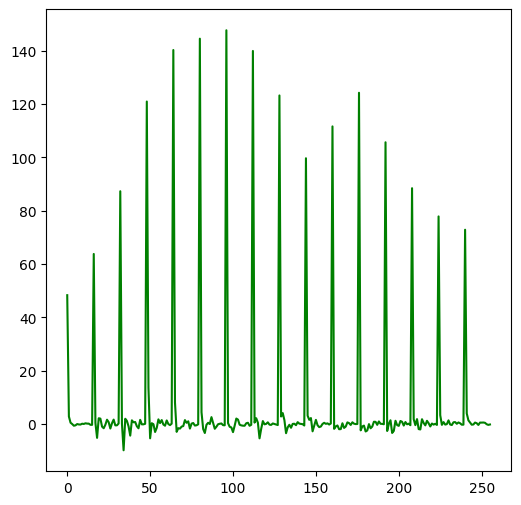

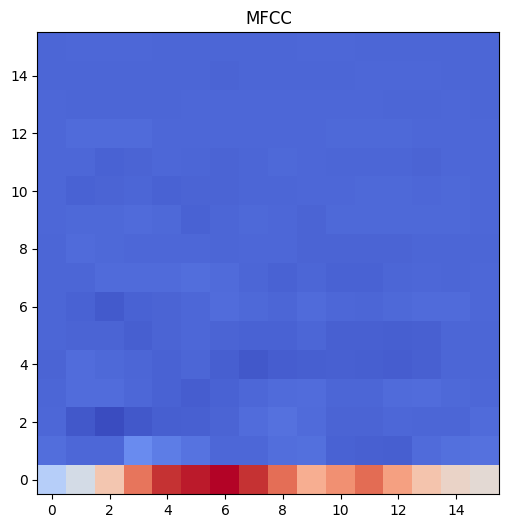

In [11]:
# Plot MFCC from Computer 
mfcc_from_time_series = np.genfromtxt('mfcc_from_time_series_1s.dat',delimiter='\n',dtype=None)

%matplotlib inline


plt.figure(figsize=(6,6))
plt.plot(mfcc_from_time_series,'g')
# plt.plot(mfcc,'r')

mfcc_from_time_series = mfcc_from_time_series.reshape(16,16)
fig, ax = plt.subplots(figsize=(6,6))
mfcc_from_time_series= np.swapaxes(mfcc_from_time_series, 0 ,1)
cax = ax.imshow(mfcc_from_time_series, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()

In [10]:
# Send Signal from Python & Return Inference Result from ESP32
a= function
a= a.astype(np.int16)
# a= a.astype(np.int32)


ser = serial.Serial()
ser.baudrate = 115200
ser.port = '/dev/cu.usbserial-565C0062681'
ser.open()

for i in range(len(a)):
    values = str(a[i])
    send=bytearray(values, encoding='utf8')
    jumpline=bytearray('\n', encoding='utf8')
    ser.write(send)
    ser.write(jumpline)
    print(f"send   [{i}]  : {send}")


for i in range(8500):           
    b = ser.readline()          # read a byte string
    str_rn = b.decode()
    str_input = str_rn.rstrip()
    print(f"{i}  : {str_input}")

ser.close()

send   [0]  : bytearray(b'-304')
send   [1]  : bytearray(b'-246')
send   [2]  : bytearray(b'55')
send   [3]  : bytearray(b'242')
send   [4]  : bytearray(b'606')
send   [5]  : bytearray(b'822')
send   [6]  : bytearray(b'1298')
send   [7]  : bytearray(b'1339')
send   [8]  : bytearray(b'1236')
send   [9]  : bytearray(b'920')
send   [10]  : bytearray(b'741')
send   [11]  : bytearray(b'409')
send   [12]  : bytearray(b'11')
send   [13]  : bytearray(b'-280')
send   [14]  : bytearray(b'-664')
send   [15]  : bytearray(b'-901')
send   [16]  : bytearray(b'-941')
send   [17]  : bytearray(b'-735')
send   [18]  : bytearray(b'-745')
send   [19]  : bytearray(b'-626')
send   [20]  : bytearray(b'-401')
send   [21]  : bytearray(b'-97')
send   [22]  : bytearray(b'233')
send   [23]  : bytearray(b'471')
send   [24]  : bytearray(b'743')
send   [25]  : bytearray(b'1033')
send   [26]  : bytearray(b'1377')
send   [27]  : bytearray(b'1636')
send   [28]  : bytearray(b'1696')
send   [29]  : bytearray(b'1600')
send

KeyboardInterrupt: 